__LENSING__

If, when running the first notebook, you get an error related to config files. For example, it may state that the label 'numba' could not be found in a config file, or something else related to configs, this means that you have not set up your WORKSPACE path correctly to point to the folder autolens_workspace/config. To fix this, you can manually add the config path to each notebook, by uncommenting and using the following code:

In [1]:
# import autofit as af
# 
# workspace_path = "/path/to/user/autolens_workspace/"
# 
# af.conf.instance = af.conf.Config(
#     config_path=workspace_path + "config/",
#     output_path=workspace_path + "output/",
# )

In [ ]:
%load_ext lab_black

from autolens.plotters import grid_plotters
from autolens.model.profiles import light_profiles as lp
from autolens.model.profiles import mass_profiles as mp
from autolens.model.galaxy import galaxy as g
from autolens.lens import ray_tracing
from autolens.model.profiles.plotters import profile_plotters
from autolens.model.galaxy.plotters import galaxy_plotters
from autolens.data.array import grids
from autolens.lens.plotters import plane_plotters
from autolens.lens.plotters import ray_tracing_plotters

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


The fundamental quantity in strong lens modeling are grids of (y,x) coordinates (e.g. in arc-seconds) that are deflected and traced by the strong lensing system. Before lensing, the grid of coordinates is the 'image-plane' grid, which is a regular 2D grid.

We can make an image-plane grid with PyAutoLens as below, where this grid consists of 100 x 100 coordinates and has a pixel-to-arcsecond conversion scale of 0.05".

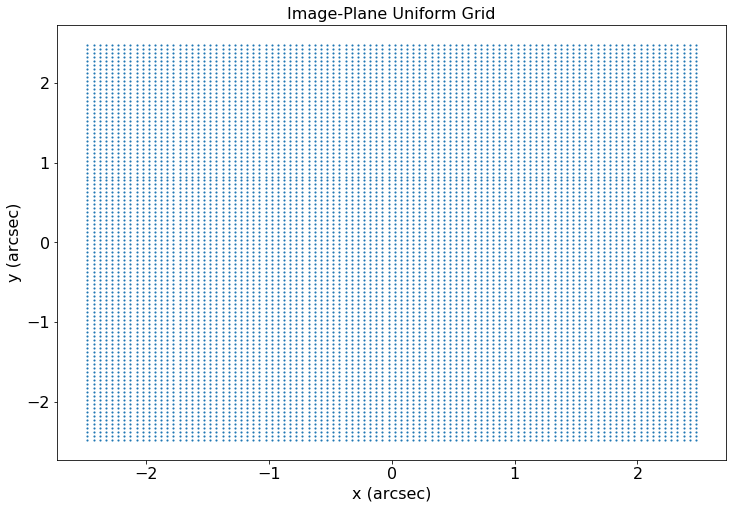

In [ ]:
image_plane_grid = grids.Grid.from_shape_pixel_scale_and_sub_grid_size(
    shape=(100, 100), pixel_scale=0.05, sub_grid_size=1
)

grid_plotters.plot_grid(grid=image_plane_grid, title="Image-Plane Uniform Grid")

To perform ray-tracing, we create a 'mass-profile'. A mass-profile is an analytic function that describes a distribution of mass, and therefore can be used to derive its surface-density, gravitational potential and most importantly, its deflection angles. For those unfamiliar with lensing, the deflection angles describe how light is bent by a mass-profile due to how its potential curves space-time.

In [ ]:
sis_mass_profile = mp.EllipticalIsothermal(
    centre=(0.0, 0.0), axis_ratio=0.9, phi=45.0, einstein_radius=1.6
)

mass_profile_deflections = sis_mass_profile.deflections_from_grid(
    grid=image_plane_grid, return_in_2d=False
)

The deflection angles describe how the grid's coordinates are traced from the image-plane (the plane we observed the lensed source in) to the source-plane (the plane where the source appears unlensed). We can subtract the deflection angles from the regular-grid to get this source-plane grid.

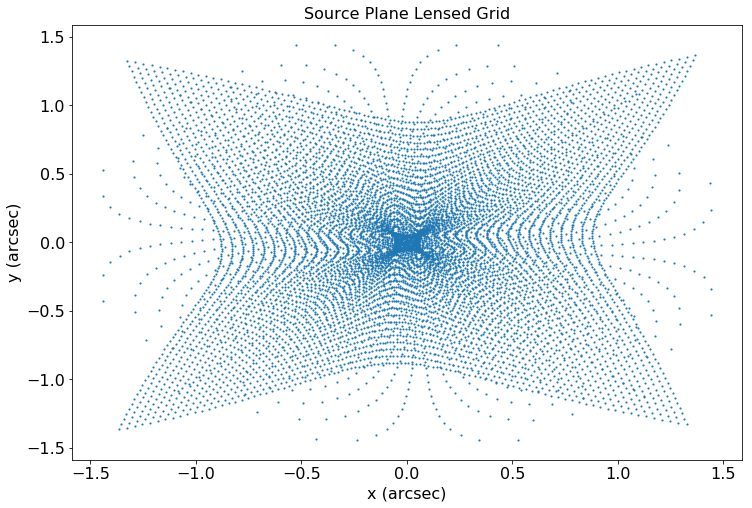

In [ ]:
source_plane_grid = image_plane_grid - mass_profile_deflections

grid_plotters.plot_grid(grid=source_plane_grid, title="Source Plane Lensed Grid")

Now that we can use mass profiles to map between grids, we can use them to 'trace' light-rays through our model strong lens systems. light-profiles work just like mass profiles, in that we set them up using some analytic profile (an elliptical Sersic below) and pass them grids to perform calculations.

Below, we evaluate and plot our Sersic light profile on the regular and lensed grid, which shows how the galaxy's light is changed by the mass profile above.

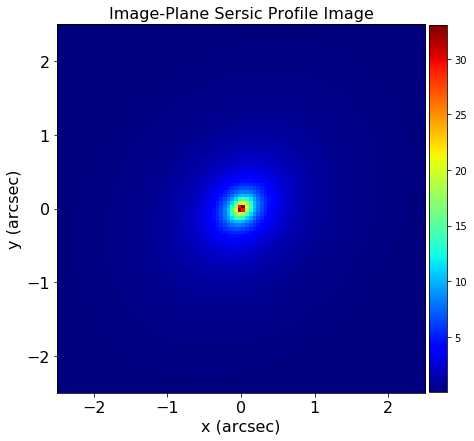

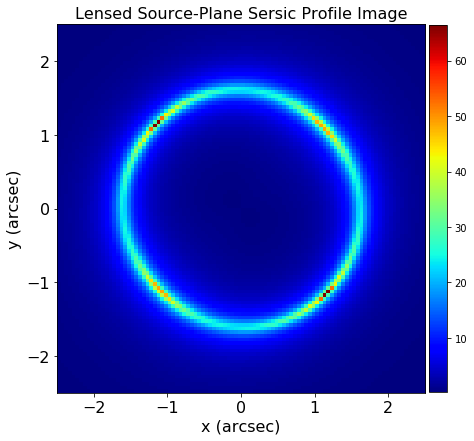

In [ ]:
sersic_light_profile = lp.EllipticalSersic(
    centre=(0.0, 0.0),
    axis_ratio=0.8,
    phi=45.0,
    intensity=1.0,
    effective_radius=1.0,
    sersic_index=2.5,
)

profile_plotters.plot_intensities(
    light_profile=sersic_light_profile,
    grid=image_plane_grid,
    title="Image-Plane Sersic Profile Image",
)

profile_plotters.plot_intensities(
    light_profile=sersic_light_profile,
    grid=source_plane_grid,
    title="Lensed Source-Plane Sersic Profile Image",
)

To perform lensing, we make 'Galaxies' from light and mass profiles, where:

1) Galaxies can be made from multiple light-profiles and mass-profiles.
2) By taking multiple components, the summed intensities / deflection angles of the profiles are computed.
3) Galaxies have redshifts, defining where they are relative to one another in lensing calculations.

Below we make a galaxy from light and mass profiles, and use this to plot some of its quantities.

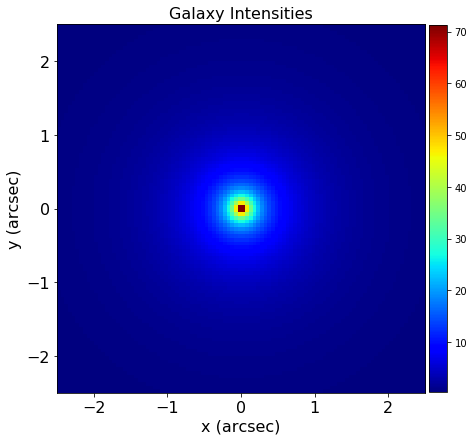

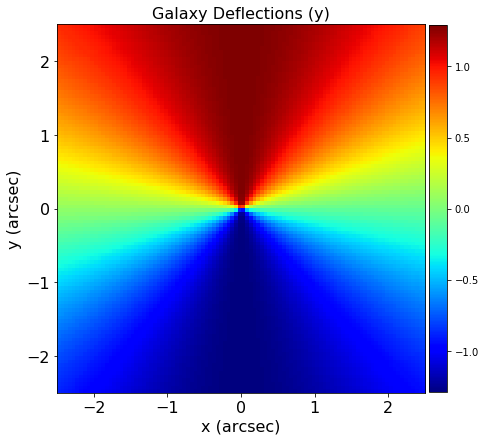

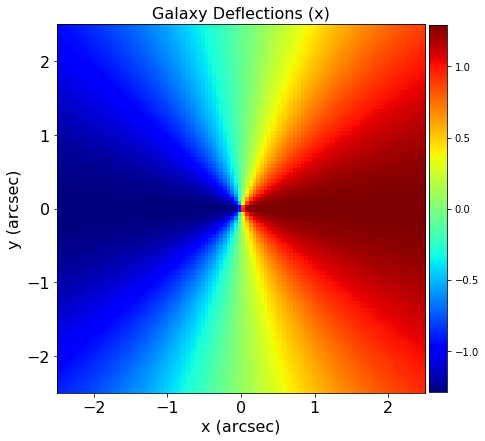

In [ ]:
light_profile_1 = lp.SphericalExponential(
    centre=(0.0, 0.0), intensity=1.0, effective_radius=1.0
)

light_profile_2 = lp.SphericalSersic(
    centre=(0.0, 0.0), intensity=1.0, effective_radius=2.0, sersic_index=3.0
)

mass_profile_1 = mp.SphericalIsothermal(centre=(0.0, 0.0), einstein_radius=0.3)

mass_profile_2 = mp.EllipticalIsothermal(
    centre=(0.0, 0.0), axis_ratio=0.8, phi=45.0, einstein_radius=1.0
)

galaxy = g.Galaxy(
    redshift=0.5,
    light_1=light_profile_1,
    light_2=light_profile_2,
    mass_1=mass_profile_1,
    mass_2=mass_profile_2,
)

galaxy_plotters.plot_intensities(galaxy=galaxy, grid=image_plane_grid)
galaxy_plotters.plot_deflections_y(galaxy=galaxy, grid=image_plane_grid)
galaxy_plotters.plot_deflections_x(galaxy=galaxy, grid=image_plane_grid)

To perform lensing, all we need are multiple galaxies at different redshifts. For a 2-plane strong lens system, we have a ray-tracing scenario like the one shown below:

In [8]:
#  Observer                  Image-Plane               Source-Plane
#  (z=0, Earth)               (z = 0.5)                (z = 1.0)
#
#           ----------------------------------------------
#          /                                              \ <---- This is one of the source's light-rays
#         /                      __                       \
#    o   /                      /  \                      __
#    |  /                      /   \                     /  \
#   /\  \                      \   /                     \__/
#        \                     \__/                 Source Galaxy (s)
#         \                Lens Galaxy(s)                /
#           \                                           / <----- And this is its other light-ray
#            ------------------------------------------/

We can pass galaxies into the 'ray_tracing' module in PyAutoLens to create the strong lens system above. You'll note below that we first create a 'grid-stack' - this object contains our regular grid above but also other types of grids that perform ray tracing calculations at different levels of accuracy and precision.

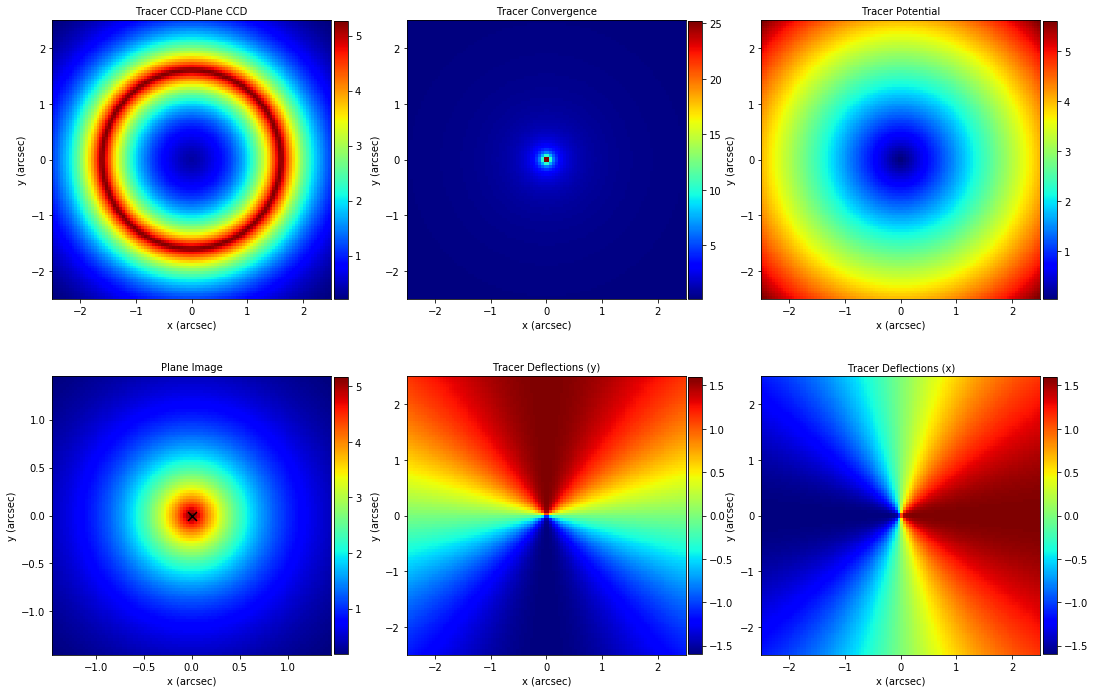

In [ ]:
image_plane_grid_stack = grids.GridStack.from_shape_pixel_scale_and_sub_grid_size(
    shape=(100, 100), pixel_scale=0.05, sub_grid_size=2
)

lens_galaxy = g.Galaxy(
    redshift=0.5, mass=mp.SphericalIsothermal(centre=(0.0, 0.0), einstein_radius=1.6)
)

source_galaxy = g.Galaxy(
    redshift=1.0,
    light=lp.SphericalSersic(
        centre=(0.0, 0.0), intensity=1.0, effective_radius=1.0, sersic_index=1.0
    ),
)

tracer = ray_tracing.Tracer.from_galaxies_and_image_plane_grid_stack(
    galaxies=[lens_galaxy],
    galaxies=[source_galaxy],
    image_plane_grid_stack=image_plane_grid_stack,
)

ray_tracing_plotters.plot_ray_tracing_subplot(tracer=tracer)

The ray-tracing module actually uses the redshifts of the input galaxies to setup the strong lens system above. It does this on a plane-by-plane basis, and thus for the input above using two galaxies, creates two planes, an image-plane and source-plane.

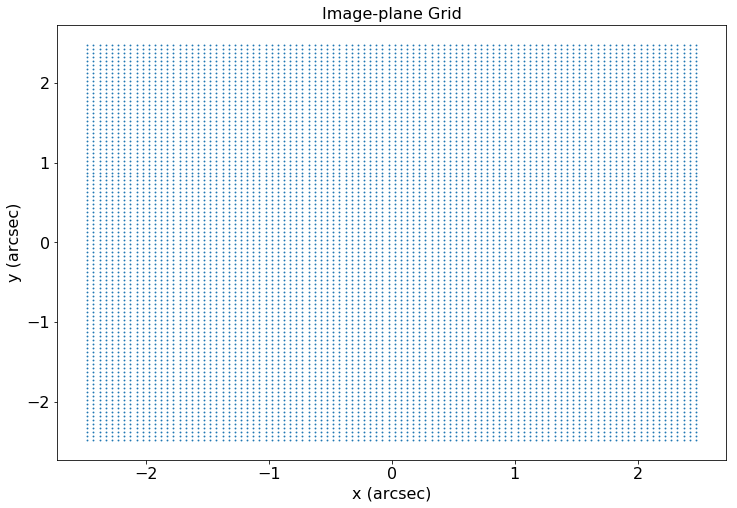

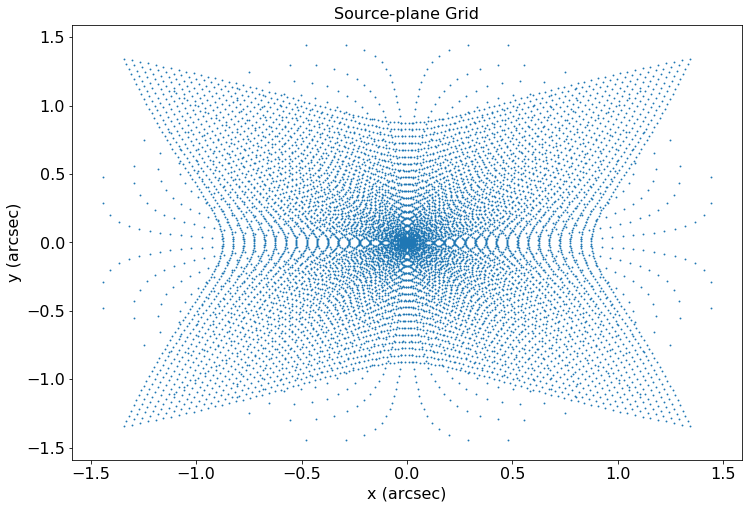

In [ ]:
plane_plotters.plot_plane_grid(plane=tracer.image_plane, title="Image-plane Grid")

plane_plotters.plot_plane_grid(plane=tracer.source_plane, title="Source-plane Grid")

And this completes the first section of the quick-start tutorial. Hopefully you'll agree that performing ray-tracing calculations in PyAutoLens is really straight-forward! Before continuing, I'd advise you do the following to the tracer above:

- Change the lens galaxy mass profile to an EllipticalIsothermal - what happens?
- Add more lens and source galaxies to the tracer.
- Change the resolution (pixel-scale) of the image-plane grid stack.